In [183]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [243]:
import numpy as np
import pandas as pd
from scipy import stats

In [244]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [245]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [246]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [247]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)


In [248]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [249]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [250]:
# Create our session (link) from Python to the DB
session = Session (bind=engine)

In [251]:
inspector = inspect(engine)


In [252]:
inspector.get_table_names()

['measurement', 'station']

In [253]:
columns = inspector.get_columns('measurement')
for column in columns:
    print (column['name'])

id
station
date
prcp
tobs


In [254]:
columns = inspector.get_columns('station')
for column in columns:
    print (column['name'])

id
station
name
latitude
longitude
elevation


# Exploratory Climate Analysis

In [306]:
max_date = session.query(func.max(Measurement.date)).all()[0][0]
max_date = dt.datetime.strptime(max_date, '%Y-%m-%d')
max_date

datetime.datetime(2017, 8, 23, 0, 0)

In [307]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
query_date = max_date - dt.timedelta(days=365)
results = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= query_date).all()

results [:5]

[('2016-08-24', 0.08),
 ('2016-08-25', 0.08),
 ('2016-08-26', 0.0),
 ('2016-08-27', 0.0),
 ('2016-08-28', 0.01)]

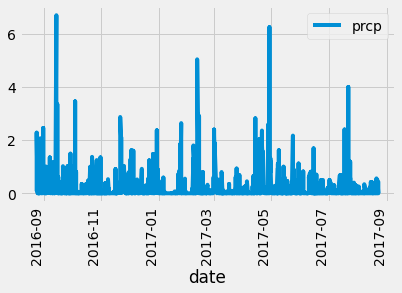

In [308]:
# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_df = pd.DataFrame(results)
precipitation_df.dropna(inplace=True)

precipitation_df["date"] = pd.to_datetime(precipitation_df["date"])


# Sort the dataframe by date
precipitation_df.set_index('date', inplace=True)


# Use Pandas Plotting with Matplotlib to plot the data

precipitation_df.plot(rot=90)

In [258]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [259]:
# Design a query to show how many stations are available in this dataset?
session.query(func.count(Station.station)).all()[0][0]

9

In [260]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
stations = session.query(func.count(Measurement.station), Measurement.station).group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()
stations

[(2772, 'USC00519281'),
 (2724, 'USC00519397'),
 (2709, 'USC00513117'),
 (2669, 'USC00519523'),
 (2612, 'USC00516128'),
 (2202, 'USC00514830'),
 (1979, 'USC00511918'),
 (1372, 'USC00517948'),
 (511, 'USC00518838')]

In [261]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
station_id = 'USC00519281'
session.query(func.max(Measurement.tobs), func.min(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == station_id).all()


[(85.0, 54.0, 71.66378066378067)]

In [262]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp = session.query(Measurement.date, Measurement.tobs).filter(Measurement.station == station_id).\
    filter(Measurement.date >= query_date).all()
temp[:5]

[('2016-08-24', 77.0),
 ('2016-08-25', 80.0),
 ('2016-08-26', 80.0),
 ('2016-08-27', 75.0),
 ('2016-08-28', 73.0)]

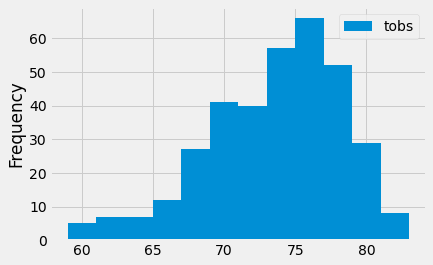

In [291]:
temp_df = pd.DataFrame(temp)
temp_df.set_index('date')
temp_df.plot(kind='hist', bins=12)

## Bonus Challenge Assignment

In [264]:
#Temperature Analysis I
#Identify the average temperature in June at all stations across all available years in the dataset. 
june_avg = session.query(func.avg(Measurement.tobs)).filter(func.strftime("%m", Measurement.date) == "06").\
    group_by(Measurement.station).all()
june_avg

[(74.13939393939394),
 (74.05084745762711),
 (76.00537634408602),
 (71.9372197309417),
 (76.6554054054054),
 (73.39473684210526),
 (73.27118644067797),
 (77.55932203389831),
 (76.66810344827586)]

In [265]:
#Do the same for December temperature.
december_avg = session.query(func.avg(Measurement.tobs)).filter(func.strftime("%m", Measurement.date) == "12").\
    group_by(Measurement.station).all()
december_avg

[(69.6842105263158),
 (71.06944444444444),
 (73.2247191011236),
 (69.29126213592232),
 (71.8348623853211),
 (72.42105263157895),
 (69.90322580645162),
 (71.10952380952381),
 (72.43333333333334)]

In [270]:
#Use the t-test to determine whether the difference in the means, if any, is statistically significant. 

stats.ttest_ind(june_avg, december_avg)

Ttest_indResult(statistic=array([4.61586542]), pvalue=array([0.00028626]))

In [275]:
#Will you use a paired t-test, or an unpaired t-test? Why?
print("An unpaired t-test is used to compare the average temperatures of two different months.")
print("Pvalue is less than 0.05 which means that there is no statistically significant different between June and December temperatures.")

An unpaired t-test is used to compare the average temperatures of two different months.
Pvalue is less than 0.05 which means that there is no statistically significant different between June and December temperatures.


In [293]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [312]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
start_date = dt.datetime(2012, 2, 28) - dt.timedelta(days=365)
end_date = dt.datetime(2012, 3, 5) - dt.timedelta(days=365)

results = session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
results

[(61.0, 70.17021276595744, 75.0)]

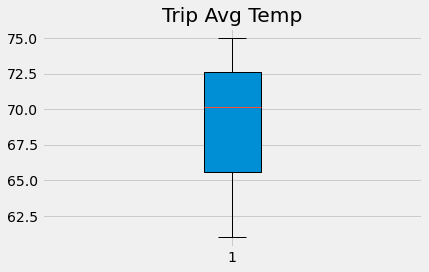

In [332]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

fig, ax = plt.subplots()

x = range(len(results))
ax.boxplot(results, patch_artist=True)
ax.set_title('Trip Avg Temp')
fig.tight_layout()
plt.show()